# All plots and Data Analysis used in the Sim Storm Paper

Please make sure to run ProcessSamiData.py in utility_programs before running anything here

## Imports

In [1]:
import aacgmv2, time
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math, os, shutil
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.io import readsav
import pymap3d as pm
import glob
import datetime, statistics
from aetherpy.io import read_routines
from math import cos, radians, sin, sqrt
from scipy import spatial, signal

from spacepy.coordinates import Coords
from spacepy.time import Ticktock
import fnmatch

import sys
from mpl_toolkits.basemap import Basemap
import geopandas

from scipy.interpolate import LinearNDInterpolator, interp1d

%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Settings

In [2]:
dtime_storm_start = datetime.datetime(2011,5,21,13,40) 
plot_start_delta  = 4   #hours before storm onset to start making plots
plot_end_delta    = 8  # hours after storm onset to end plots. Set to -1 to run for the whole time


gitm_cols = ['Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', 
             '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))',
             'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', 
             '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', 
             '[e-]', 'eTemperature', 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)'] # which gitm columns do you want plotted?
#TODO: test with not all columns!

gitm_path = "/home/axb170054/scratch/GITM-testing/test_folders/step_function_driving/SAMI3-stretch/gitm_data/"


gitm_alt_idxs = -1 #set this to -1 if you want all altitudes
gitm_keo_lons = [-90,2,90,-178]

global_lat_lim = None # will limit all plots latitude. Must be none or less than keo_lat_lim
# ^^ Needs to be tested.

keo_lat_lim = 65 # limits keos to +/- degrees of lat. 



num_pool_workers = 40 # number of workers to use in multithreading jobs. Set to 1 if you don't know what this means.

both_map_plots = True # make both_map_plots filtered and raw maps? if you only want one put it as a str ('raw'/'filt')

sample_rate_min = 5 #min
low_cut = 100 # min, lowest freq wave the filter will allow thru
high_cut = 30 # min, highest freq the filter will allow thru



available gitm cols are:
    ['Longitude', 'Latitude', 'Altitude', 'Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))', 'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', '[e-]', 'eTemperature', 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)']

In [3]:
gitm_keo_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/keos/"
gitm_map_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/maps/"

## Set up some useful functions:

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# for the maps!

In [5]:
# This will be used in plotting:
gitm_colnames_friendly = {'Rho': 'Total Neutral Density', '[O(!U3!NP)]': 'O(3P)', '[O!D2!N]': 'O2', '[N!D2!N]': 'N2', '[N(!U4!NS)]': 'N(4S)', '[NO]': 'NO', '[He]': 'He', '[N(!U2!ND)]': 'N(2D)', '[N(!U2!NP)]': 'N(2P)', '[H]': 'H', '[CO!D2!N]': 'CO2', '[O(!U1!ND)]': 'O(1D)', 'Temperature': 'Temperature', 'V!Dn!N(east)': 'Vn(east)', 'V!Dn!N(north)': 'Vn(north)', 'V!Dn!N(up)': 'Vn(up)', 'V!Dn!N(up,O(!U3!NP))': 'Vn(up,O(3P))', 'V!Dn!N(up,O!D2!N)': 'Vn(up,O2)', 'V!Dn!N(up,N!D2!N)': 'Vn(up,N2)', 'V!Dn!N(up,N(!U4!NS))': 'Vn(up,N(4S))', 'V!Dn!N(up,NO)': 'Vn(up,NO)', 'V!Dn!N(up,He)': 'Vn(up,He)', '[O_4SP_!U+!N]':'O(4Sp)+', '[NO!U+!N]': 'NO+', '[O!D2!U+!N]': 'O2+', '[N!D2!U+!N]': 'N2+', '[N!U+!N]': 'N+', '[O(!U2!ND)!U+!N]': 'O(2D)+', '[O(!U2!NP)!U+!N]': 'O(2P)+', '[H!U+!N]': 'H+', '[He!U+!N]': 'He+', '[e-]': 'e-', 'eTemperature': 'eTemperature', 'iTemperature': 'iTemperature', 'V!Di!N(east)': 'Vi(east)', 'V!Di!N(north)': 'Vi(north)', 'V!Di!N(up)': 'Vi(up)'}



In [6]:
def read_gitm_into_nparrays(flist):
    """reads a list of gitm filenames and returns a few numpy arrays.
    
    Parameters
    ----------
    flist: list
        List of gitm filenames to read in.
    
    Returns
    -------
    gitmtimes = list
        Datetimes corresponding to the times of the gitm files.
    gitmgrid = dict. 
        Holds the gitm grid for reference. lons/lats have been 
        changed to degrees from rads. Ghost cells removed.
        Keys are ['longitude', 'latitude', 'altitude']
        Index with gitmgrid[time][key][lon][lat][alt]
    gitmvars = list
        The gitm variables.
    gitmbins = numpy array. 
        All of the gitm data (except grid)
        index with gitmbins[time,varnumber,lat,lon,alt]
    
    """
    
    gitmtimes = []
    print('reading all gitm files in time range selected.')
    start = True
    for ifile, file_name in enumerate(tqdm(flist)):
        if start:
            f = read_routines.read_gitm_file(file_name)
            gitmgrid = {f['vars'][k].lower() : f[k][2:-2,2:-2,2:-2] for k in [0,1,2]}
            nlons, nlats, nalts = np.array(f[0].shape) - 4 # ghost cells
            gitmbins = np.zeros([len(flist), len(f['vars'])-3, nlons, nlats, nalts])
            gitmvars = [i for i in f['vars'][3:] if i in gitm_cols]         
            
            start = False
        else:
            f = read_routines.read_gitm_file(file_name)
        
        gitmtimes.append(f['time']) # times
        
        for var in gitm_cols:
            num_v = f['vars'].index(var)
            gitmbins[ifile, num_v-3] = f[num_v][2:-2,2:-2,2:-2] # -3 is to adjust for grid, 2's are for ghost cells
            
    gitmgrid['latitude'] = np.rad2deg(gitmgrid['latitude'])
    gitmgrid['longitude'] = np.rad2deg(gitmgrid['longitude'])
    
    ## Fix the ordering of the longitudes and go from -180-180 not 0->360 
    newlons_for_order = []
    newlons = np.zeros_like(gitmgrid['longitude'])
    for ilon in range(len(gitmgrid['longitude'])):
        oldlon = gitmgrid['longitude'][ilon,0,0]
        if oldlon <=180:
            newlons_for_order.append(int(oldlon))

        else:
            newlons_for_order.append(int(oldlon)-360) 
            gitmgrid['longitude'][ilon] = gitmgrid['longitude'][ilon] - 360

    new_lons_sorted = np.sort(newlons_for_order)
    new_order = np.array([newlons_for_order.index(new_lons_sorted[i]) for i in range(len(new_lons_sorted))])

    gitmbins = gitmbins[:,:,new_order,:,:]

    gitmgrid['longitude'] = np.sort(gitmgrid['longitude'], axis = 0)

    #enforce lat_lim:
    if global_lat_lim:
        idx_limit = np.argmin(gitmgrid['latitude'] - global_lat_lim)
        gitmbins = gitmbins[:,:,idx_limit:-idx_limit,:,:]
        gitmgrid['latitude'] = gitmgrid['latitude'][:,-idx_limit:idx_limit,:,:]
        gitmgrid['longitude']= gitmgrid['longitude'][:,-idx_limit:idx_limit,:,:]
        gitmgrid['altitude']= gitmgrid['altitude'][:,-idx_limit:idx_limit,:,:]
        
    return gitmtimes, gitmgrid, gitmvars, gitmbins

In [8]:
def bandpass_filter(low_cut, high_cut, sample_rate_min):
    sampling_frequency = 1/(sample_rate_min*60)  # Sampling frequency (in Hz) #5 mins
    low_cutoff_frequency = 1/(low_cut*60)  # Low cutoff frequency (in Hz) #90 mins
    high_cutoff_frequency = 1/(high_cut*60)  # High cutoff frequency (in Hz) #50 mins

    coefficients = signal.butter(4, [low_cutoff_frequency, high_cutoff_frequency], btype='bandpass', fs=sampling_frequency)
    bps = np.array(signal.filtfilt(coefficients[0], coefficients[1], noisy_signal))
    return bps

In [9]:
def make_filter(params = None):
    # Define the cutoff frequencies
    lowcut = 1/(100/60)  # 100 minutes in units of sample^-1
    highcut = 1/(30/60) # 30 minutes in units of sample^-1

    # Define the Butterworth filter
    nyquist = 0.5 * 5 # 5 minutes is the sampling frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = signal.butter(2, [low, high], btype='bandstop', output='sos')
    return sos

def remove_background(time_series, sos):


    # Apply the filter to the time series
    filtered_data = signal.sosfiltfilt(sos, time_series)

    return filtered_data

In [10]:
def make_fits(gitm_bins):
    """
    calculate bandpass filter for all data previously read in.
    
    inputs: nparray of gitmdata
    
    returns:
    fits: np array indexed at fits[time][col][ilon][ilat][ialt]

    
    todo: you can thread this by splitting the alts into different threads.
    then just append the fits_full later.
    
    """
    sos = make_filter()

    filtered_arr = signal.sosfiltfilt(sos, gitm_bins, axis=0)
    return filtered_arr

In [11]:
def UT_from_Storm_onset(itime):
    """input the index of timelist
    
    returns the UT as HH:MM from storm onset, as a string"""
    l = (pd.Timestamp(itime) - dtime_storm_start)/ pd.Timedelta('1 minute') # get pd datetime of this iter, find minute diff from storm start
    if l > 0:
        hrs = np.floor(l/60)
        hrs = str(int(hrs)).rjust(2,'0')
    else:
        hrs = np.ceil(l/60)
        hrs = str(int(hrs)).rjust(2,'0')
    mins = str(int(np.abs(l)%60)).rjust(2,'0')
    ut = hrs + ':' + mins
    return ut

In [406]:
def remove_outliers(array):
    arr2 = array.copy()
    mean, std, median = np.mean(arr2), np.std(arr2), np.median(arr2) # calculate mean, standard deviation, and median over all elements
    outlier_threshold = 5 # set outlier threshold (in terms of number of standard deviations)
    outliers = np.logical_or(arr2 < mean - outlier_threshold * std, arr2 > mean + outlier_threshold * std) # find outliers
    arr2[outliers] = median # set outliers to median
    return arr2

In [407]:
def make_a_keo(arr, title, cbarlims, cbar_name, 
               y_label = 'Latitude (deg)', x_label = 'Hours since storm onset', save_or_show = 'save' , fname = None,
               plot_extent = [-plot_start_delta, plot_end_delta, -keo_lat_lim, keo_lat_lim]):
    """
    Inputs a data array and then generates a keogram.
    
    Parameters:
    -----------
    arr: np array
        The data array to be plotted. If grabbing from the gitm array, you do not need to transpose.
    extent: tuple/list
        The limits of the plot. [left, right, bottom, top]
    xlabel: string
        self-explanitory
    y-label: string
        self-explanitory
    title: string
        self-explanitory
    cbar limes: tuple/list
        vmin, vmax for the colorbar to be plot.
    cbar_name: string.
        Label for the colorbar.
    save_or_show: string
        Defaults to save. You can instead 'show' the plots. 
    
    """
    
    fig = plt.figure(figsize = (10,7))
    if keo_lat_lim:
        if arr.shape.index(len(lats)) ==0:
            idx_limit = np.argmin(np.abs(lats - keo_lat_lim))
            arr = arr[-idx_limit:idx_limit, :]
        elif arr.shape.index(len(lats)) ==1:
            idx_limit = np.argmin(np.abs(lats - keo_lat_lim))
            arr = arr[:, -idx_limit:idx_limit]

    plt.imshow(arr.T, extent = plot_extent, aspect = 'auto', cmap = 'viridis', origin = 'lower', vmin = cbarlims[0], vmax = cbarlims[1])
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.colorbar(label = cbar_name)
    
    if save_or_show == 'show':
        plt.show()
        plt.close()
    elif save_or_show == 'save':
        if not fname:
            raise ValueError('plot save path must be given!')
        else:
            try:
                plt.savefig(fname)
            except FileNotFoundError:
                directory_list = os.path.join(fname).split('/')[:-1]
                os.makedirs('/'+os.path.join(*directory_list))
                plt.savefig(fname)
            plt.close('all')
    else:
        raise ValueError('save_or_show input is invalid. Accepted inputs are "save" or "show", you gave ', save_or_show)


## Do GITM Plots First

In [14]:
gitm_files = np.sort(glob.glob(gitm_path+'3DALL*'))

gitm_dtimes = []
for i in gitm_files:
    yy, MM, dd, hr, mm, sec = i[-17:-15], i[-15:-13], i[-13:-11], i[-10:-8], i[-8:-6], i[-6:-4]
    gitm_dtimes.append(datetime.datetime(int('20' + yy), int(MM), int(dd), int(hr), int(mm), int(sec)))
    
storm_start_index = np.argmin(np.abs(np.array(gitm_dtimes)-dtime_storm_start))
plot_start_idx = np.argmin(np.abs(np.array(gitm_dtimes)-(dtime_storm_start - datetime.timedelta(hours = plot_start_delta))))
plot_end_idx = np.argmin(np.abs(np.array(gitm_dtimes)-(dtime_storm_start + datetime.timedelta(hours = plot_end_delta)))) if plot_end_delta != -1 else -1

### Read in all gitm files

In [15]:
times, gitm_grid, gitm_vars, gitm_bins = read_gitm_into_nparrays(gitm_files[plot_start_idx:plot_end_idx])

reading all gitm files in time range selected.


  0%|          | 0/144 [00:00<?, ?it/s]

In [ ]:
gitm_grid.

In [16]:
lats, lons, alts  = np.unique(gitm_grid['latitude']), np.unique(gitm_grid['longitude']), np.unique(gitm_grid['altitude'])

### Calculate the fits for df

This is used in keos and the maps. Faster to just do it all now rather than have it done multiple times.

In [17]:
print('Calculating fits. This will take a moment...')
fits_gitm = make_fits(gitm_bins)


Calculating fits. This will take a moment...


In [58]:
lat_lim = np.max(gitm_grid['latitude'])

## Keograms! of all columns!

In [19]:
times[0], np.datetime64(dtime_storm_start)

(datetime.datetime(2011, 5, 21, 9, 40, 0, 234000),
 numpy.datetime64('2011-05-21T13:40:00.000000'))

In [20]:
lats, lons, alts

(array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5,
        -80.5, -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5,
        -71.5, -70.5, -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5,
        -62.5, -61.5, -60.5, -59.5, -58.5, -57.5, -56.5, -55.5, -54.5,
        -53.5, -52.5, -51.5, -50.5, -49.5, -48.5, -47.5, -46.5, -45.5,
        -44.5, -43.5, -42.5, -41.5, -40.5, -39.5, -38.5, -37.5, -36.5,
        -35.5, -34.5, -33.5, -32.5, -31.5, -30.5, -29.5, -28.5, -27.5,
        -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18.5,
        -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,  -9.5,
         -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
          0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
         18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
         27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
      

### Define some useful variables:

In [21]:
hrs_since_storm = np.array([(i - pd.Timestamp(dtime_storm_start)) / pd.Timedelta('1 hour') for i in times])
if gitm_alt_idxs == -1:
    gitm_alt_idxs = list(range(len(alts)))

### Make plots:

In [408]:
# KEO MAKING FUNCTIONS:

#TODO: get rid of either name_col or num_col. or make it so that we can give either. 

def call_keos(alt_idx, real_lon, numcol= None, namecol = None,  save_or_show = 'show', return_figs = False, figtype = 'all', outliers = False):
    if numcol == None and namecol != None:
        numcol = gitm_cols.index(namecol)
    elif namecol == None and numcol != None:
        namecol = gitm_cols[numcol]
    elif numcol == None and namecol == None:
        raise ValueError('either namecol or numcol must be specified!')

    vmin_bins = np.min(gitm_bins[:,numcol,:,:,alt_idx])
    vmax_bins = np.max(gitm_bins[:,numcol,:,:,alt_idx])
    
    vmin_fits = np.min(fits_gitm[:,numcol,:,:,alt_idx])
    vmax_fits = np.max(fits_gitm[:,numcol,:,:,alt_idx])
    
    vmin_diffs = np.min(100*(fits_gitm[:,numcol,:,:,alt_idx] - gitm_bins[:,numcol,:,:,alt_idx])/gitm_bins[:,numcol,:,:,alt_idx])
    vmax_diffs = np.max(100*(fits_gitm[:,numcol,:,:,alt_idx] - gitm_bins[:,numcol,:,:,alt_idx])/gitm_bins[:,numcol,:,:,alt_idx])

    #get data.
    lon_idx = np.argmin(np.abs(lons - real_lon))
    data = gitm_bins[:,numcol,lon_idx,:,alt_idx].copy()
    bandpass = fits_gitm[:,numcol,lon_idx,:,alt_idx].copy()
    real_alt = alts[alt_idx]
    percent = 100*(data - bandpass)/bandpass
    
    if outliers:
        data = remove_outliers(data)
        bandpass = remove_outliers(bandpass)
        percent = remove_outliers(percent)
        
    
    if figtype == 'all' or 'filt' in figtype:
        #plain bandpass filter
        title = 'Keogram of %s along %i deg Longitude at %i km' %(gitm_colnames_friendly[namecol].replace('(','[').replace(')',']'), real_lon, round(real_alt/1000,0))
        color_label = 'Bandpass filter'
        # print(gitm_keo_save_path, real_alt, real_lon, namecol)
        # print(int(real_alt/1000,0), int(real_lon))
        fname = os.path.join(gitm_keo_save_path, 'bandpass',  str(int(real_alt/1000)), 'lon'+str(int(real_lon)),  gitm_colnames_friendly[namecol] + '.png')
        make_a_keo(bandpass, title, cbarlims=(vmin_fits,vmax_fits), cbar_name=color_label,save_or_show=save_or_show, fname = fname)

    if figtype == 'all' or 'raw' in figtype:
        #plain raw data
        title = 'Keogram of %s along %i deg Longitude at %i km' %(gitm_colnames_friendly[namecol].replace('(','[').replace(')',']'), real_lon, round(real_alt/1000,0))
        color_label = 'Raw data'
        fname = os.path.join(gitm_keo_save_path, 'raw',  str(int(real_alt/1000)), 'lon'+str(int(real_lon)), gitm_colnames_friendly[namecol] + '.png')
        make_a_keo(data, title, cbarlims=(vmin_bins,vmax_bins), cbar_name=color_label,save_or_show=save_or_show, fname = fname)

    if figtype == 'all' or 'diff' in figtype:
        #(bandpass - raw)/ raw
        title = 'Keogram of %s along %i deg Longitude at %i km' %(gitm_colnames_friendly[namecol].replace('(','[').replace(')',']'), real_lon, round(real_alt/1000,0))
        color_label = '% over bandpass filter'
        fname = os.path.join(gitm_keo_save_path, 'percent-over-filter',  str(int(real_alt/1000)), 'lon'+str(int(real_lon)), gitm_colnames_friendly[namecol] + '.png')
        make_a_keo(percent, title, cbarlims=(vmin_diffs,vmax_diffs), cbar_name=color_label,save_or_show=save_or_show, fname = fname)
    

    
    
def thread_call_keos(args):
    call_keos(args[2], args[3],args[0], args[1], outliers=args[4],  save_or_show = 'save', return_figs = False, figtype = 'all')
    

    
def loop_keos(sel_cols, sel_alts, sel_lons, save_or_show = 'show', return_figs = False, figtype = 'all', thread = False, outliers = False):
    #make sure inputs are lists so we can loop through them.
    if type(sel_cols) is not list: 
        if type(sel_cols) is not np.array:
            sel_cols = [ sel_cols ]
    if type(sel_alts) is not list: 
        if type(sel_alts) is not np.array:
            sel_alts = [ sel_alts ]
    if type(sel_lons) is not list: 
        if type(sel_lons) is not np.array:
            sel_lons = [ sel_lons ]

    
    if not thread: #make plots sequentially
        pbar = tqdm(desc = 'making keos..', total = len(sel_lons) * len(sel_alts) * len(sel_cols))
        for namecol in sel_cols:
            numcol = gitm_cols.index(icol)
            for nalt in sel_alts:
                for ilon in sel_lons:
                    call_keos(nalt,ilon,numcol,namecol, save_or_show, return_figs, figtype, outliers)
                
    
    else: # build an array of all plot arguments. then plot all the args across the number of processors specified in num_pool_workers.
        arg_arr = []
        print("thread is True. Building array and launching pool... (pbar is just an estimate. It will not be 100% accurate since we're threading.)")
        
        for namecol in sel_cols:
            numcol = gitm_cols.index(namecol)
            for nalt in sel_alts:
                for ilon in sel_lons:
                    arg_arr.append([numcol,namecol,nalt,ilon,outliers])
                    
        with Pool(num_pool_workers) as pool:
            with tqdm(desc = 'threading keo making', total = len(arg_arr)) as pbar:
                for _ in pool.imap_unordered(thread_call_keos, arg_arr):
                    pbar.update(1)
            
                    

       

In [90]:
#USAGE:

# loop_keos(sel_cols = gitm_cols, sel_alts = gitm_alt_idxs, sel_lons = lons, debug = True, save_or_show = 'save')

In [55]:
loop_keos(sel_cols = gitm_cols, sel_alts = gitm_alt_idxs, sel_lons = gitm_keo_lons, debug = False, save_or_show = 'save', thread = True)

thread is True. Building array and launching pool...


threading keo making:   0%|          | 0/7400 [00:00<?, ?it/s]

## Now map time

In [88]:
len(times), gitm_bins.shape

(144, (144, 37, 90, 180, 50))

In [130]:

def draw_map(data_arr, title, cbarlims, cbar_label = None,
             y_label = 'Latitude (deg)', x_label = 'Hours since storm onset', save_or_show = 'save' , fname = None,
             plot_extent = [min(lons), max(lons), -lat_lim, lat_lim]):
    
    fig,ax = plt.subplots(figsize = (10,5))
    world.plot(ax = ax, color = 'white', edgecolor = 'black', zorder = 1)
    data = ax.imshow(data_arr, cmap = 'viridis', aspect = 'auto', extent = plot_extent, origin = 'lower',
                           zorder = 10, alpha = 0.8, vmin = cbarlims[0], vmax = cbarlims[1], interpolation='bicubic', interpolation_stage='rgba')
    plt.title(title)
    if not cbar_label:
        fig.colorbar(data)
    else:
        fig.colorbar(data, label = cbar_label)
    
    
    if save_or_show == 'show':
        plt.show()
        plt.close()
    elif save_or_show == 'save':
        if fname == None:
            raise ValueError('plot save path must be given!')
        else:
            try:
                plt.savefig(fname)
            except FileNotFoundError:
                directory_list = os.path.join(fname).split('/')[:-1]
                os.makedirs('/'+os.path.join(*directory_list))
                plt.savefig(fname)
            plt.close()
    else:
        raise ValueError('save_or_show input is invalid. Accepted inputs are "save" or "show", you gave ', save_or_show)
        
        
def call_maps(alt_idx, dtime_real = None, dtime_index = None, numcol = None, namecol = None,  save_or_show = 'show', return_figs = False, figtype = 'all', outliers = False):
    #Make sure inputs are correct. either the index or actual value of the datetime and column to plot can be specified (or both).
    if numcol == None and namecol != None:
        numcol = gitm_cols.index(namecol)
    elif namecol == None and numcol != None:
        namecol = gitm_cols[numcol]
    elif numcol == None and namecol == None:
        raise ValueError('either namecol or numcol must be specified!')
        
    if dtime_real == None and dtime_index != None:
        dtime_real = times[dtime_index]
    elif dtime_index == None and dtime_real != None:
        dtime_index = times.index(dtime_real)
    elif dtime_real == None and dtime_index == None:
        raise ValueError('either dtime_index or dtime_real must be specified!')

    #get colorbar limits.
    vmin_bins = np.min(gitm_bins[:,numcol,:,:,alt_idx])
    vmax_bins = np.max(gitm_bins[:,numcol,:,:,alt_idx])
    
    vmin_fits = np.min(fits_gitm[:,numcol,:,:,alt_idx])
    vmax_fits = np.max(fits_gitm[:,numcol,:,:,alt_idx])
    
    vmin_diffs = np.min(100*(fits_gitm[:,numcol,:,:,alt_idx] - gitm_bins[:,numcol,:,:,alt_idx])/gitm_bins[:,numcol,:,:,alt_idx])
    vmax_diffs = np.max(100*(fits_gitm[:,numcol,:,:,alt_idx] - gitm_bins[:,numcol,:,:,alt_idx])/gitm_bins[:,numcol,:,:,alt_idx])
    
    #get data. 
    raw = gitm_bins[dtime_index,numcol,:,:,alt_idx].copy()
    bandpass = fits_gitm[dtime_index,numcol,:,:,alt_idx].copy()
    real_alt = alts[alt_idx]
    percent = 100*(bandpass - raw)/raw
    
    if outliers:
        raw = remove_outliers(raw)
        bandpass = remove_outliers(bandpass)
        percent = remove_outliers(percent)
    
    #raw map
    if figtype == 'all' or 'raw' in figtype:
        title = gitm_colnames_friendly[namecol] + ' at ' + str(round(float(real_alt)/1000,0)) +' km at ' + UT_from_Storm_onset(dtime_real) +  " from Storm Start"
        fname = os.path.join(gitm_map_save_path,'raw', str(int(real_alt/1000)), gitm_colnames_friendly[namecol], str(dtime_index).rjust(3,'0') + '.png')
        cbarlims = [vmin_bins, vmax_bins]
        draw_map(raw, title, cbarlims, fname = fname, save_or_show= save_or_show)
        

    #filter map
    if figtype == 'all' or 'filt' in figtype:
        title = gitm_colnames_friendly[namecol] + ' at ' + str(round(float(real_alt)/1000,0)) +' km at ' + UT_from_Storm_onset(dtime_real) +  " from Storm Start"
        fname = os.path.join(gitm_map_save_path,'filt', str(int(real_alt/1000)), gitm_colnames_friendly[namecol], str(dtime_index).rjust(3,'0') + '.png')
        cbarlims = [vmax_fits, vmax_fits]
        cbar_label = 'Bandpass Filtered ' + gitm_colnames_friendly[namecol]
        draw_map(bandpass, title, cbarlims, save_or_show= save_or_show, cbar_label = cbar_label, fname = fname)
        
        
    #diffs
    if figtype == 'all' or 'raw' in figtype:
        title = gitm_colnames_friendly[namecol] + ' at ' + str(round(float(real_alt)/1000,0)) +' km at ' + UT_from_Storm_onset(dtime_real) +  " from Storm Start"
        fname = os.path.join(gitm_map_save_path,'diff', str(int(real_alt/1000)), gitm_colnames_friendly[namecol], str(dtime_index).rjust(3,'0') + '.png')
        cbarlims = [vmin_diffs, vmax_diffs]
        cbar_label = '% over Background'
        draw_map(percent, title, cbarlims, save_or_show= save_or_show, cbar_label = cbar_label, fname = fname)        
        
        
        
def thread_call_maps(args):
    call_maps(alt_idx=args[0], namecol = args[1], dtime_real = args[2], outliers = args[3],  save_or_show = 'save', return_figs = False, figtype = 'all', outliers = False)
        
def loop_maps(sel_cols, sel_alts, save_or_show = 'show', return_figs = False, figtype = 'all', thread = False, outliers = False):
    #make sure inputs are lists so we can loop through them.
    if type(sel_cols) is not list: 
        if type(sel_cols) is not np.array:
            sel_cols = [ sel_cols ]
    if type(sel_alts) is not list: 
        if type(sel_alts) is not np.array:
            sel_alts = [ sel_alts ]

    
    if not thread: #make plots sequentially
        pbar = tqdm(desc = 'making maps..', total = len(times) * len(sel_alts) * len(sel_cols))
        for namecol in sel_cols:
            numcol = gitm_cols.index(namecol)
            for nalt in sel_alts:
                for dtime_real in times:
                    call_maps(nalt, dtime_real = dtime_real, numcol = numcol, save_or_show = save_or_show, return_figs = return_figs, figtype = figtype, outliers = outliers)
                    pbar.update(1)
                    
    
    else: # build an array of all plot arguments. then plot all the args across the number of processors specified in num_pool_workers.
        arg_arr = []
        print("thread is True. Building array and launching pool... (pbar is just an estimate. It will not be 100% accurate since we're threading.)")
        
        for namecol in sel_cols:
            numcol = gitm_cols.index(namecol)
            for nalt in sel_alts:
                for dtime_real in times:
                    arg_arr.append([nalt,namecol,dtime_real,outliers])
    
        with Pool(num_pool_workers) as pool:
            with tqdm(desc = 'threading map making', total = len(arg_arr)) as pbar:
                for _ in pool.imap_unordered(thread_call_maps, arg_arr):
                    pbar.update(1)       
        


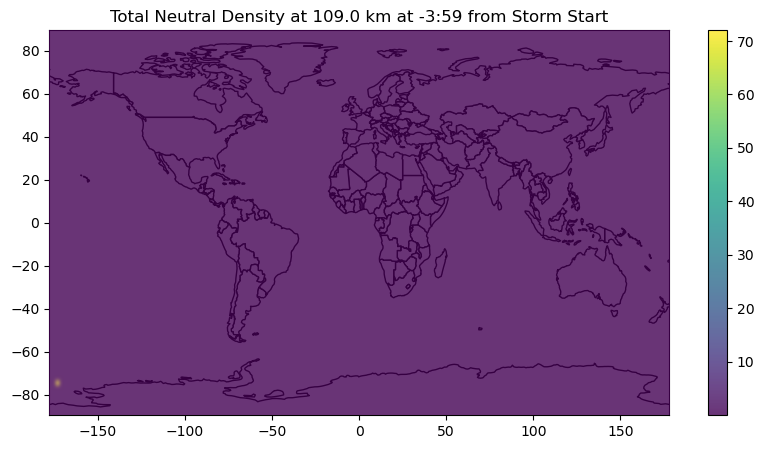

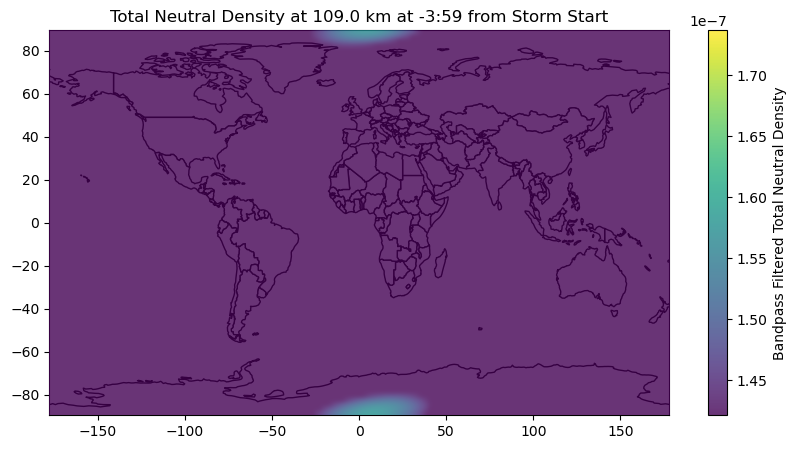

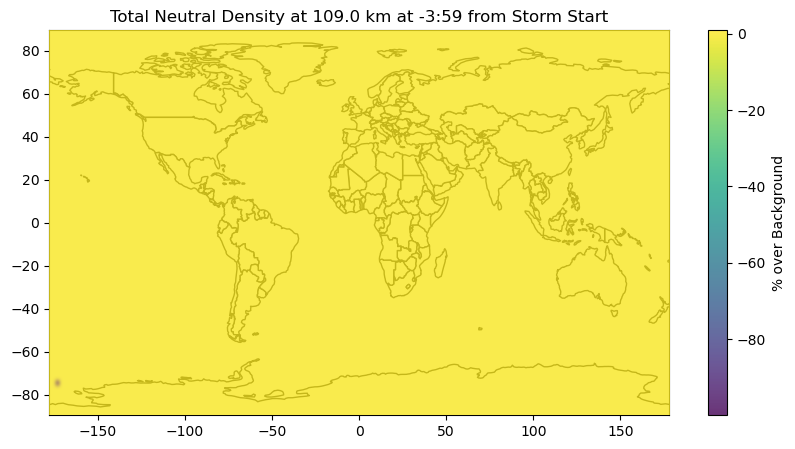

In [405]:
# [0,0,:,:,5]
call_maps(5, dtime_index = 0, numcol = 0, save_or_show='show')

In [132]:
#USAGE

# call_maps(alt_idx = 5,  dtime_index = 14, numcol = 0,  save_or_show = 'save', figtype = 'all')
# loop_maps(gitm_cols, gitm_alt_idxs, thread = False)

In [120]:

loop_maps(gitm_cols, gitm_alt_idxs, save_or_show='save', thread = True)

thread is True. Building array and launching pool... (pbar is just an estimate. It will not be 100% accurate since we're threading.)


threading map making:   0%|          | 0/266400 [00:00<?, ?it/s]

Process ForkPoolWorker-578:
Process ForkPoolWorker-586:
Process ForkPoolWorker-582:
Process ForkPoolWorker-587:
Process ForkPoolWorker-567:
Process ForkPoolWorker-564:
Process ForkPoolWorker-585:
Process ForkPoolWorker-572:
Process ForkPoolWorker-583:
Traceback (most recent call last):
Process ForkPoolWorker-591:
Process ForkPoolWorker-584:
Process ForkPoolWorker-581:
Process ForkPoolWorker-579:
Process ForkPoolWorker-577:
Process ForkPoolWorker-580:
Process ForkPoolWorker-571:
Exception ignored in: Process ForkPoolWorker-552:
Process ForkPoolWorker-556:
Process ForkPoolWorker-570:
Process ForkPoolWorker-576:
Process ForkPoolWorker-555:
Process ForkPoolWorker-588:
Traceback (most recent call last):
Process ForkPoolWorker-560:
Process ForkPoolWorker-561:
Traceback (most recent call last):
Process ForkPoolWorker-575:
Process ForkPoolWorker-558:
Process ForkPoolWorker-574:
Process ForkPoolWorker-559:
  File "/home/axb170054/.conda/envs/py38/lib/python3.8/multiprocessing/process.py", line 

In [ ]:
gitm_keo_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/keos-outliers/"
gitm_map_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/maps-outliers/"

In [ ]:
loop_keos(sel_cols = gitm_cols, sel_alts = gitm_alt_idxs, sel_lons = gitm_keo_lons, debug = False, save_or_show = 'save', thread = True, outliers = True)

In [ ]:
loop_maps(gitm_cols, gitm_alt_idxs, save_or_show='save', thread = True, outliers = True)

In [134]:
for n, c in enumerate(gitm_cols):
    print(n,c)

0 Rho
1 [O(!U3!NP)]
2 [O!D2!N]
3 [N!D2!N]
4 [N(!U4!NS)]
5 [NO]
6 [He]
7 [N(!U2!ND)]
8 [N(!U2!NP)]
9 [H]
10 [CO!D2!N]
11 [O(!U1!ND)]
12 Temperature
13 V!Dn!N(east)
14 V!Dn!N(north)
15 V!Dn!N(up)
16 V!Dn!N(up,O(!U3!NP))
17 V!Dn!N(up,O!D2!N)
18 V!Dn!N(up,N!D2!N)
19 V!Dn!N(up,N(!U4!NS))
20 V!Dn!N(up,NO)
21 V!Dn!N(up,He)
22 [O_4SP_!U+!N]
23 [NO!U+!N]
24 [O!D2!U+!N]
25 [N!D2!U+!N]
26 [N!U+!N]
27 [O(!U2!ND)!U+!N]
28 [O(!U2!NP)!U+!N]
29 [H!U+!N]
30 [He!U+!N]
31 [e-]
32 eTemperature
33 iTemperature
34 V!Di!N(east)
35 V!Di!N(north)
36 V!Di!N(up)


In [137]:
nc = 13
a = 4

In [307]:
gitm_bins2 = gitm_bins.copy()

In [308]:
times, gitm_grid, gitm_vars, gitm_bins = read_gitm_into_nparrays(gitm_files[plot_start_idx:plot_end_idx])

reading all gitm files in time range selected.


  0%|          | 0/144 [00:00<?, ?it/s]

In [312]:
np.product(gitm_bins.shape)

4315680000

In [313]:
(gitm_bins == gitm_bins2).sum()

4315679999

In [311]:
gitm_bins[0,0,7,2,5] = 72

In [314]:
sys.getsizeof(gitm_bins), sys.getsizeof(gitm_bins2)

(176, 34525440176)

In [316]:
gitm_bins.flags

  C_CONTIGUOUS : False
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

In [317]:
gitm_bins2.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

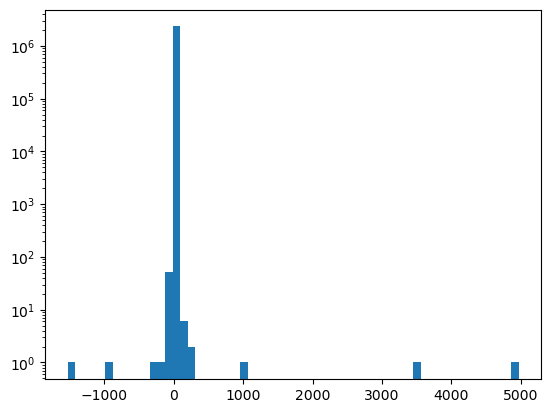

In [322]:
l = ((fits_gitm[:,nc,:,:,a] - gitm_bins[:,nc,:,:,a])/gitm_bins[:,nc,:,:,a]).copy()
plt.hist(l.flatten(), bins = 60);
plt.yscale('log')

In [323]:
np.unravel_index(l.argmax(), l.shape)

(16, 15, 78)

(-0.025, 0.025)

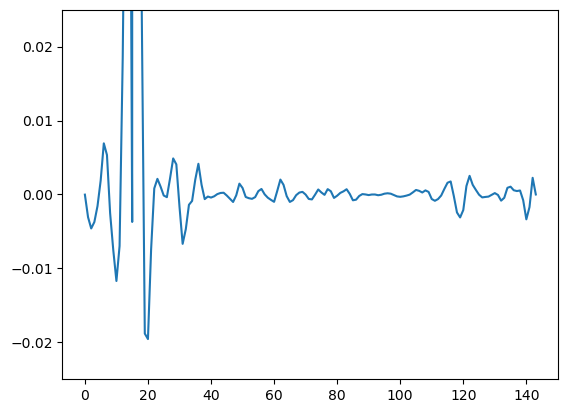

In [324]:
plt.plot(l[:,15,78])
plt.ylim([-.025,.025])

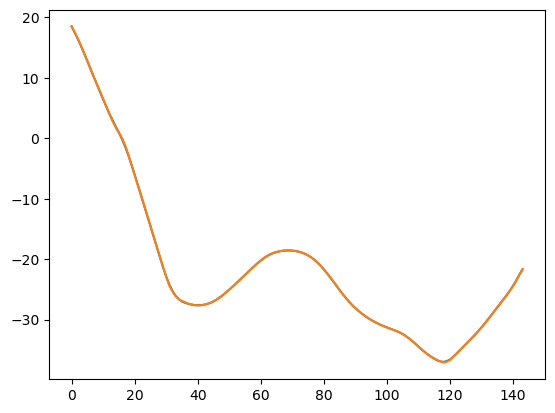

In [325]:
plt.plot(fits_gitm[:,nc,15,78,a])
plt.plot(gitm_bins[:,nc,15,78,a])

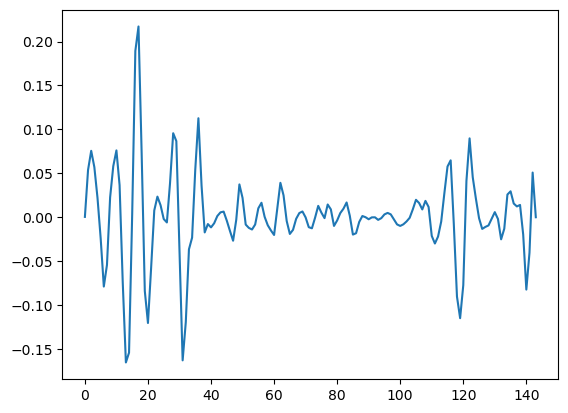

In [326]:
plt.plot(gitm_bins[:,nc,15,78,a]-fits_gitm[:,nc,15,78,a])

In [327]:
fits_resids = (fits_gitm - gitm_bins) / gitm_bins

In [328]:
fits_resids.shape

(144, 37, 90, 180, 50)

In [329]:
l = fits_resids[:,nc,:,:,a].copy()
l2 = l[16,:,:].copy()
l2.shape

(90, 180)

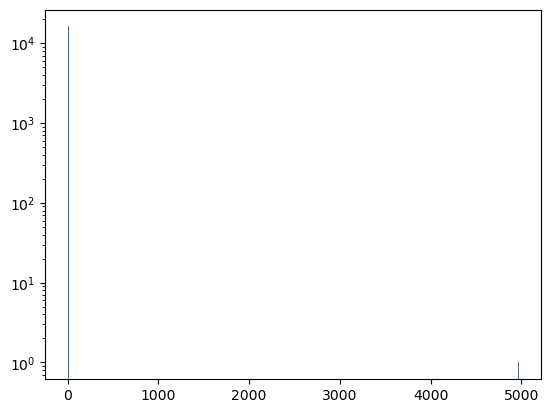

In [330]:
plt.hist(l2.flatten(), bins = 450)
plt.yscale('log')

In [331]:
median, stdev = np.median(l[16,:,:]), np.std(l[16,:,:])

In [332]:
median, stdev

(-1.0626009755602596e-07, 39.04098297960775)

In [299]:
fits_resids[13,0,:,:,6]

array([[-1.17265561e-05,  6.06187692e-07, -3.09894397e-05, ...,
        -2.73633711e-05,  5.46377225e-06, -1.59047543e-05],
       [-1.62010363e-05,  9.45893258e-06,  2.32041689e-05, ...,
         5.23070977e-06, -2.76468831e-05, -9.81766289e-06],
       [-8.78998767e-06,  7.23692042e-06,  4.28850703e-05, ...,
         1.61278898e-05, -3.82281154e-05, -1.05189463e-05],
       ...,
       [-5.06385028e-06, -3.91589925e-05, -4.98787101e-05, ...,
         1.88283577e-05, -6.62544431e-06, -7.33986671e-06],
       [ 7.67336072e-08, -3.07426043e-05, -3.25374840e-05, ...,
        -2.40981749e-08,  1.25825279e-05, -7.73557699e-06],
       [-2.87040466e-06, -1.50890098e-05, -4.36390151e-05, ...,
         2.57047171e-06,  7.88631631e-06, -1.03118843e-05]])

In [ ]:
n,vals = plt.hist(fits_resids[0,7,:,:,5], bins = 50)
plt.show()

In [396]:
arr = fits_resids[0,0,:,:,5].copy()
arr2 = arr.copy()
mean, std, median = np.mean(arr2), np.std(arr2), np.median(arr2) # calculate mean, standard deviation, and median over all elements
outlier_threshold = 5 # set outlier threshold (in terms of number of standard deviations)
outliers = np.logical_or(arr2 < mean - outlier_threshold * std, arr2 > mean + outlier_threshold * std) # find outliers
arr2[outliers] = median # set outliers to median

In [397]:
outliers.sum()

1

In [398]:
np.unravel_index(arr.argmin(), arr.shape)

(7, 2)

In [399]:
arr[7,2], arr2[7,2]

(-0.9999999986437439, 1.3596052329386648e-08)

In [400]:
fits_resids[0,0,7,2,5], gitm_bins[0,0,7,2,5], fits_gitm[0,0,7,2,5]

(-0.9999999986437439, 72.0, 9.765044806063828e-08)

In [401]:
outliers[7,2]

True

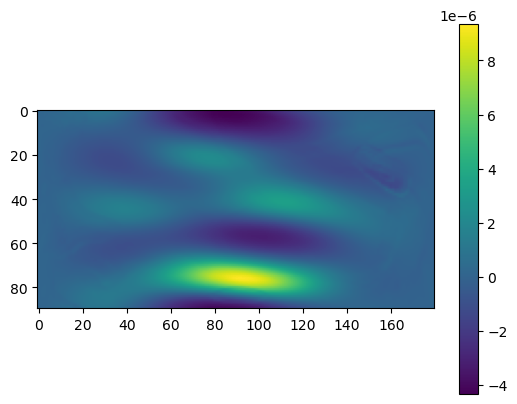

In [402]:
plt.imshow(arr2)
plt.colorbar()

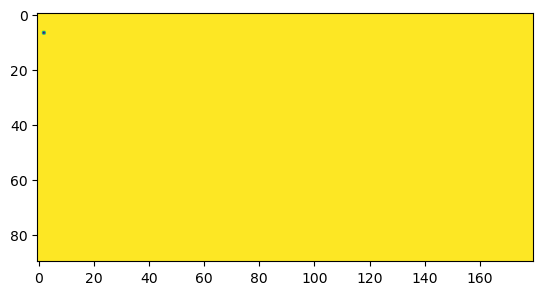

In [403]:
plt.imshow(arr)

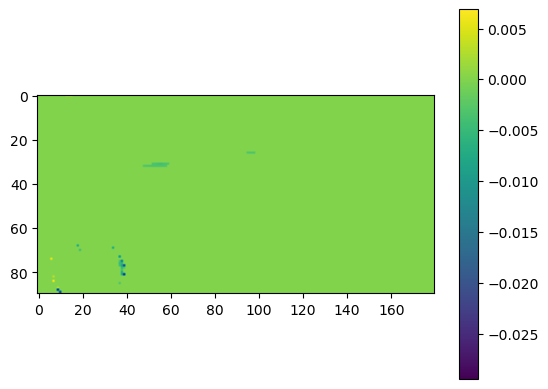

In [387]:
plt.imshow(arr2-arr)
plt.colorbar()

In [388]:
(arr2 == arr).sum()

16150

In [389]:
90*180

16200

In [391]:
arr.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False

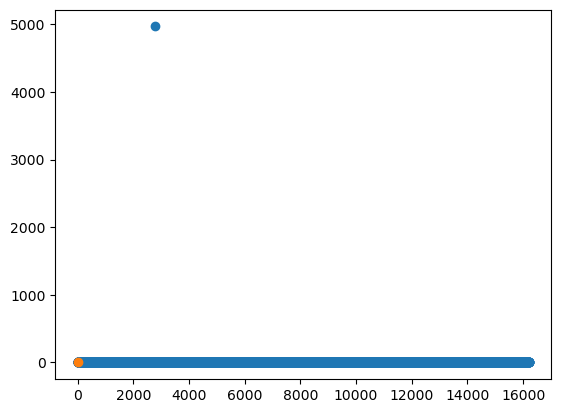

In [392]:
plt.scatter(range(len(l[16,:,:].flatten())), l[16,:,:])
plt.scatter(0,np.min(p))

In [394]:
arr = np.random.rand(180, 90) # example array
mean, std = np.mean(arr), np.std(arr) # calculate mean and standard deviation over all elements
outlier_threshold = 3 # set outlier threshold (in terms of number of standard deviations)
outliers = np.logical_or(arr < mean - outlier_threshold * std, arr > mean + outlier_threshold * std) # find outliers


In [395]:
outliers.sum()

0

making maps..:   0%|          | 0/24864 [00:00<?, ?it/s]

/home/axb170054/scratch/made_plots/SimStormPaper/maps/no-bg-removed/109/Total Neutral Density/000.png


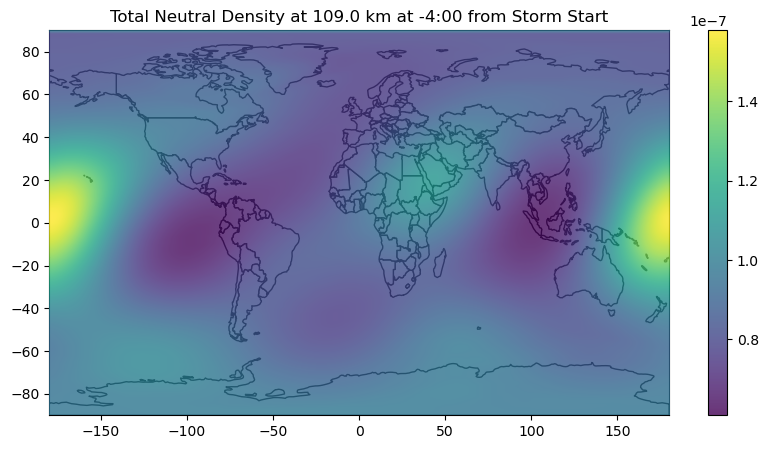

/home/axb170054/scratch/made_plots/SimStormPaper/maps/bandpass-fit/109/Total Neutral Density/000.png


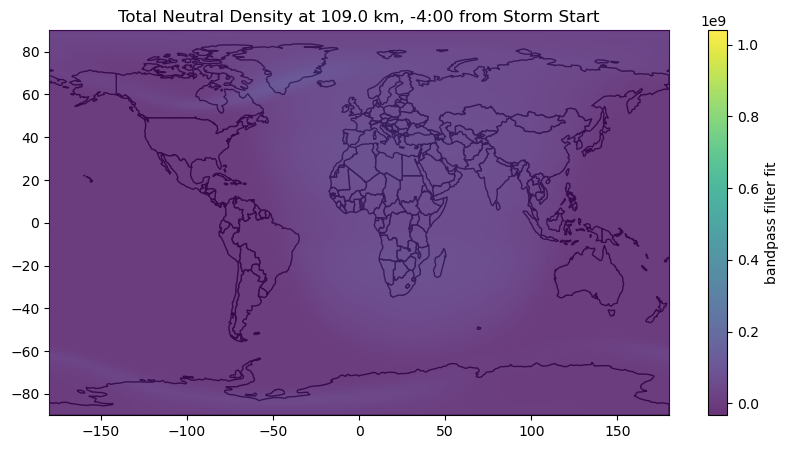

/home/axb170054/scratch/made_plots/SimStormPaper/maps/bandpass-fit/109/Total Neutral Density/000.png


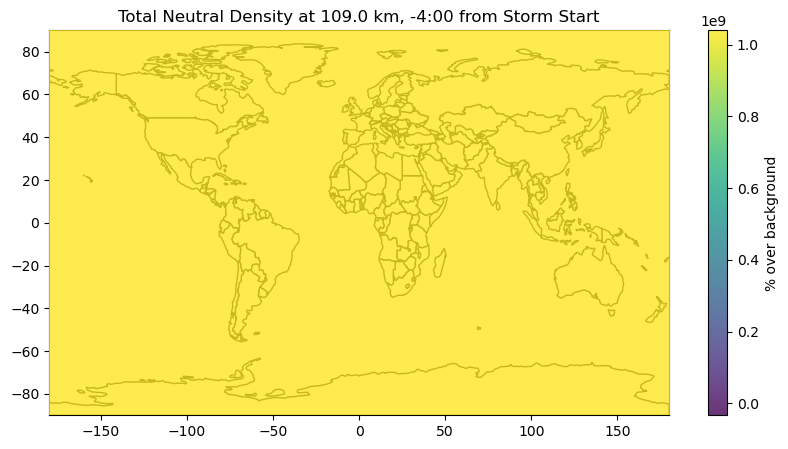

In [102]:
to_save = True

debug = True

pbar = tqdm(desc = 'making maps..', total = len(alts) * len(times) * len(gitm_cols))

for nalt, ialt in enumerate(alts):
    # df_sel = df[(df.alt == ialt)].reset_index(drop = True)
    

    for nt, time in enumerate(times):
        # df_time = df_sel[df_sel.dtime == time].reset_index(drop = True)
        
        for ncol,icol in enumerate(gitm_cols):
            
            minraw = np.min(df_sel[icol]) #min/max raw
            maxraw = np.max(df_sel[icol])
            
            if both_map_plots or both_map_plots == 'filt':
                # minfit = np.min(fits_full[nalt,:,:,ncol,:]) #min/max of fits
                # maxfit = np.max(fits_full[nalt,:,:,ncol,:])
                # Get fits into df, then this will be easier!
            
            # make arr of zeros, fill it with data. Done once for both_map_plots plot types.
            arr = np.zeros((len(lats), len(lons)))

            for i in range(len(df_time)):
                lon = np.argmin(np.abs(lons - df_time['lon'][i])) #find index of lon
                lat = np.argmin(np.abs(lats - df_time['lat'][i])) #find index of lat
                arr[-lat][lon] = df_time[icol][i] #-needed because matplotlib plots upside-down

                
            if both_map_plots or both_map_plots == 'raw':
                
                
            
                fig,ax = plt.subplots(figsize = (10,5))
                world.plot(ax = ax, color = 'white', edgecolor = 'black', zorder = 1)
                data = ax.imshow(arr, cmap = 'viridis', aspect = 'auto', extent = [-180,180,-90,90], 
                           zorder = 10, alpha = 0.8, vmin = minraw, vmax = maxraw, interpolation='bicubic', interpolation_stage='rgba')

                plt.title(gitm_colnames_friendly[icol] + ' at ' + str(round(float(ialt)/1000,0)) +' km at '
                          + UT_from_Storm_onset(time) +  " from Storm Start")
                fig.colorbar(data)

                if to_save:
                    fname = os.path.join(gitm_map_save_path,'no-bg-removed', str(int(ialt/1000)), gitm_colnames_friendly[icol].replace('(','[').replace(')',']'))

                    if debug:
                        print(fname + '/' + str(nt).rjust(3,'0') + '.png')
                        plt.show()
                        plt.close()
                        if not both_map_plots or both_map_plots == 'raw':
                            break
                    else:
                        if os.path.exists(fname):
                            plt.savefig(fname + '/' + str(nt).rjust(3,'0') + '.png')
                            plt.close()
                        else:
                            os.makedirs(fname)
                            plt.savefig(fname + '/' + str(nt).rjust(3,'0') + '.png')
                            plt.close()

                else:            
                    plt.show()
                    plt.close()

                    if debug:       
                        break
                        
            if both_map_plots or both_map_plots == 'filt':                
                #make plot, plot worls, show arr
                fig,ax = plt.subplots(figsize = (10,5))
                world.plot(ax = ax, color = 'white', edgecolor = 'black', zorder = 1)
                
                # make data array: fits[ialt][ilat][ilon][col][time_array, len = len(times)]
                fit_here = fits_full[nalt,:,:,ncol,nt]
                
                data = ax.imshow(fit_here, cmap = 'viridis', aspect = 'auto', extent = [-180,180,-90,90], 
                           zorder = 10, alpha = 0.8, vmin = minfit, vmax = maxfit, interpolation='bicubic', interpolation_stage='rgba')

                plt.title(gitm_colnames_friendly[icol] + ' at ' + str(round(float(ialt)/1000,0)) +' km, '
                          + UT_from_Storm_onset(time) +  " from Storm Start")
                plt.colorbar(data, label = 'bandpass filter fit')

                if to_save:
                    fname = os.path.join(gitm_map_save_path,'bandpass-fit', str(int(ialt/1000)), gitm_colnames_friendly[icol].replace('(','[').replace(')',']'))

                    if debug:
                        print(fname + '/' + str(nt).rjust(3,'0') + '.png')
                        plt.show()
                        plt.close()
                    else:
                        if os.path.exists(fname):
                            plt.savefig(fname + '/' + str(nt).rjust(3,'0') + '.png')
                            plt.close()
                        else:
                            os.makedirs(fname)
                            plt.savefig(fname + '/' + str(nt).rjust(3,'0') + '.png')
                            plt.close()
                else:            
                    plt.show()
                    plt.close()
                
                
                
                #now plot out the data - fit:
                fig,ax = plt.subplots(figsize = (10,5))
                world.plot(ax = ax, color = 'white', edgecolor = 'black', zorder = 1)
                
                # make data array: fits[ialt][ilat][ilon][col][time_array, len = len(times)]
                fit_here = fits_full[nalt,:,:,ncol,nt]
                
                data = ax.imshow((fit_here - arr)/arr, cmap = 'viridis', aspect = 'auto', extent = [-180,180,-90,90], 
                           zorder = 10, alpha = 0.8, vmin = minfit, vmax = maxfit, interpolation='bicubic', interpolation_stage='rgba')

                plt.title(gitm_colnames_friendly[icol] + ' at ' + str(round(float(ialt)/1000,0)) +' km, '
                          + UT_from_Storm_onset(time) +  " from Storm Start")
                plt.colorbar(data, label = '% over background')

                if to_save:
                    fname = os.path.join(gitm_map_save_path,'bandpass-fit', str(int(ialt/1000)), gitm_colnames_friendly[icol].replace('(','[').replace(')',']'))

                    if debug:
                        print(fname + '/' + str(nt).rjust(3,'0') + '.png')
                        plt.show()
                        plt.close()
                    else:
                        if os.path.exists(fname):
                            plt.savefig(fname + '/' + str(nt).rjust(3,'0') + '.png')
                            plt.close()
                        else:
                            os.makedirs(fname)
                            plt.savefig(fname + '/' + str(nt).rjust(3,'0') + '.png')
                            plt.close()
                else:            
                    plt.show()
                    plt.close()
                
                
                
                
                if debug:
                    break
                
                pbar.update(1)
            
        if debug: 
            break
        
    if debug:
        break

In [103]:
fits_full.flatten()[:5]

array([7164244.51055823, 7412466.44147109, 7666567.50160897,
       7908331.95921555, 8168291.81316845])

In [104]:
df_time.head(5)

,alt,lat,lon,dtime,Rho,[O(!U3!NP)],[O!D2!N],[N!D2!N],[N(!U4!NS)],[NO],...,[O(!U2!ND)!U+!N],[O(!U2!NP)!U+!N],[H!U+!N],[He!U+!N],[e-],eTemperature,iTemperature,V!Di!N(east),V!Di!N(north),V!Di!N(up)
0,109292.436412,-89.5,2.0,2011-05-21 09:40:00,9.781481e-08,2.912883e+17,3.066493e+17,1.571676e+18,1.701506e+12,3.335227e+12,...,72385.816235,35628.463728,1.0,3.531023e-15,5.288618e+10,204.811242,225.292367,13.805700,98.212810,-19.625231
1,109292.436412,-88.5,2.0,2011-05-21 09:40:00,9.792469e-08,2.900693e+17,3.078861e+17,1.573305e+18,1.790180e+12,3.762479e+12,...,89957.909054,44434.712534,1.0,3.526795e-15,5.931223e+10,207.468074,228.214882,20.206664,143.845500,-30.161132
2,109292.436412,-87.5,2.0,2011-05-21 09:40:00,9.795592e-08,2.885450e+17,3.088190e+17,1.573776e+18,1.876817e+12,4.227456e+12,...,109365.996485,54157.745026,1.0,3.524138e-15,6.584765e+10,208.239890,229.063879,22.276891,189.338618,-41.549893
3,109292.436412,-86.5,2.0,2011-05-21 09:40:00,9.788380e-08,2.866750e+17,3.092546e+17,1.572806e+18,1.971399e+12,4.759468e+12,...,130589.979406,64809.280124,1.0,3.522230e-15,7.239435e+10,209.577890,230.535679,19.895756,228.176690,-52.352644
4,109292.436412,-85.5,2.0,2011-05-21 09:40:00,9.769737e-08,2.849991e+17,3.092038e+17,1.569840e+18,2.110577e+12,5.435998e+12,...,175084.869706,87011.428125,1.0,3.521063e-15,8.380160e+10,211.990400,233.189440,16.225663,258.832633,-61.452501


In [52]:
fits_full.shape

(180, 90, 37, 168)

In [53]:
fits_full[0][0][0]

array([ 7164244.51055823,  7412466.44147109,  7666567.50160897,
        7908331.95921555,  8168291.81316845,  8408585.89507967,
        8666295.19841437,  8921870.54522678,  9166868.0818339 ,
        9441783.19311118,  9680690.3308648 ,  9952069.41585834,
       10202626.02224262, 10462921.46026424, 10729592.67163019,
       11000247.32473342, 11259988.40052598, 11529063.34285094,
       11726917.36238896, 11946571.96406418, 12034464.55008877,
       12202822.6969599 , 12196245.06335586, 12357815.00877762,
       12311429.80757086, 12488080.89654642, 12434375.90813438,
       12614287.06952911, 12561302.21627561, 12725787.10188521,
       12680864.47359158, 12817232.12727308, 12788659.61740105,
       12887899.96660026, 12883951.8179617 , 12928383.39254862,
       12941521.44207921, 12928815.39651292, 12927992.13440285,
       12949633.73105435, 12914874.61233731, 12998775.41804808,
       12828487.0105086 , 12339637.69524474, 11890088.67378805,
       10097058.09067301,  9861997.72827

In [439]:
test

,A,B,C
0,1,2,3
1,4,5,6
2,7,8,9


In [440]:
test.loc[len(test)] = [5,6,7]

In [441]:
test

,A,B,C
0,1,2,3
1,4,5,6
2,7,8,9
3,5,6,7


In [260]:
len(alts), len(times), len(gitm_cols), len(alts) * len(times) * len(gitm_cols)

(4, 168, 37, 24864)

In [337]:
alt

109292.43641210737

In [335]:
dtime_storm_start + datetime.timedelta(hours = 1)

datetime.datetime(2011, 5, 21, 14, 40)

In [ ]:
df_location = df_sel[(df_sel.lat == df_time.lat[i]) & (df_sel.lon == df_time.lon[i])].reset_index(drop = True)
fit = remove_background(df_location[icol])

In [ ]:
pd.to_timedelta

In [384]:
p=0
while p < len(times):
    l = (df['dtime'][p*len(alts)*len(lats)*len(lons)] - dtime_storm_start)/ pd.Timedelta('1 minute')
    if l > 0:
        hrs = np.floor(l/60)
        hrs = str(int(hrs)).rjust(2,'0')
    else:
        hrs = np.ceil(l/60)
        hrs = str(int(hrs)).rjust(2,'0')
    mins = np.abs(l)%60
    # print(hrs, mins, l, t , dtime_storm_start, p)
    print("%s:%s from storm start" %(hrs, str(int(mins)).rjust(2,'0')))
    p+=10

-4:00 from storm start
-3:10 from storm start
-2:20 from storm start
-1:30 from storm start
00:40 from storm start
00:10 from storm start
01:00 from storm start
01:50 from storm start
02:40 from storm start
03:30 from storm start
04:20 from storm start
05:10 from storm start
06:00 from storm start
06:50 from storm start
07:40 from storm start
08:30 from storm start
09:20 from storm start


In [371]:
np.floor(235/60)

3.0

In [373]:
-235%60

5

In [317]:
icol

'Rho'

In [327]:
for i in range(len(df_time)):
    df_location = df_sel[(df_sel.lat == df_time.lat[i]) & (df_sel.lon == df_time.lon[i])].reset_index(drop = True)
    fit = remove_background(df_location[icol])
    
    
    
    break

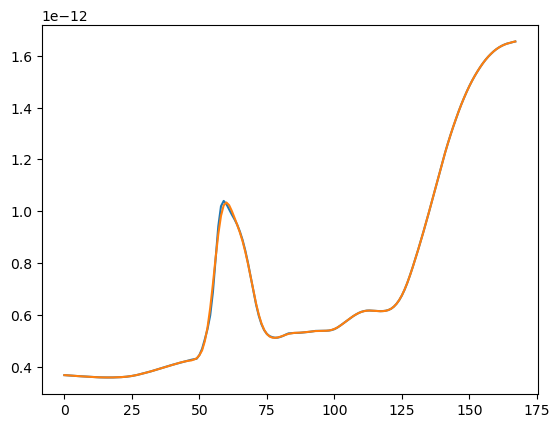

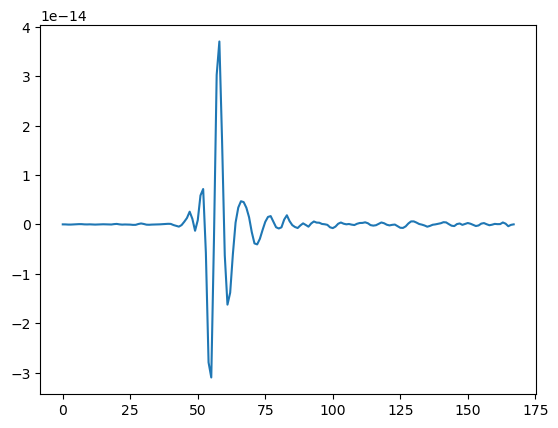

2011-05-21 09:40:00


In [332]:
plt.plot(df_location[icol])
plt.plot(fit)
plt.show()
plt.close()

plt.plot(df_location[icol] - fit)
plt.show()
plt.close()
print(df_time['dtime'][i])

In [334]:
times[storm_start_index]

IndexError: index 452 is out of bounds for axis 0 with size 168

In [284]:

arr.shape, len(lats), len(lons)

((180, 90), 180, 90)

In [316]:
fits.keys(), fits[2].keys(), fits[2][136877.51637131226].keys()

(dict_keys([-90, 2, 90, -178]),
 dict_keys([109292.43641210737, 136877.51637131226, 319673.6422589202, 513110.21404279757]),
 dict_keys(['Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))', 'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', '[e-]', 'eTemperature', 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)']))

In [308]:
arr = np.zeros((len(lats), len(lons)))
for i in range(len(df_time)):
    lon = np.argmin(np.abs(lons - df_time['lon'][i]))
    lat = np.argmin(np.abs(lats - df_time['lat'][i]))
    arr[-lat][lon] = df_time[icol][i]

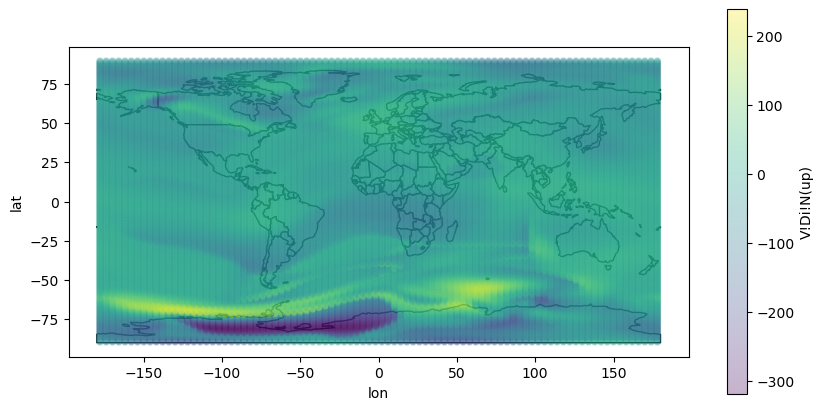

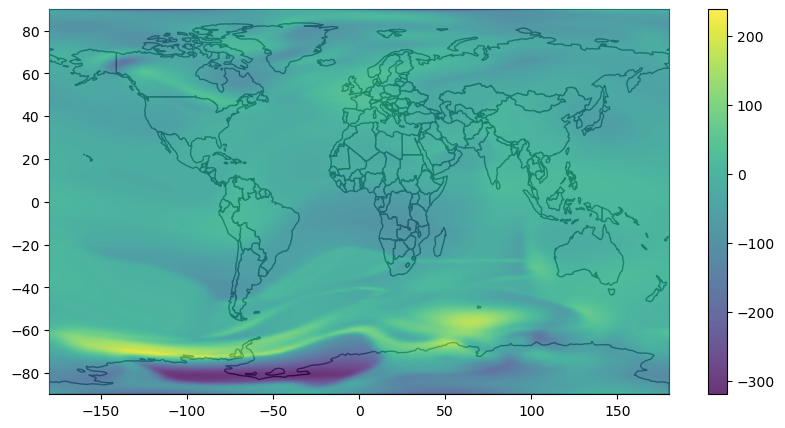

In [310]:
fig,ax = plt.subplots(figsize = (10,5))
world.plot(ax = ax, color = 'white', edgecolor = 'black', zorder = 1)
df_time.plot(ax = ax, x = 'lon', y = 'lat', c = icol, kind = 'scatter', colormap = 'viridis', alpha = 0.3);
plt.show()
plt.close()

fig,ax = plt.subplots(figsize = (10,5))
world.plot(ax = ax, color = 'white', edgecolor = 'black', zorder = 1)
#df_loc.plot(ax = ax, x = 'lon', y = 'lat', c = 'Rho', kind = 'scatter', colormap = 'viridis', alpha = 0.3);
plt.imshow(arr, cmap = 'viridis', aspect = 'auto', extent = [-180,180,-90,90], zorder = 10, alpha = 0.8, interpolation='bicubic')
plt.colorbar()
plt.show()
plt.close()

In [304]:
df_time

,alt,lat,lon,dtime,Rho,[O(!U3!NP)],[O!D2!N],[N!D2!N],[N(!U4!NS)],[NO],...,[O(!U2!ND)!U+!N],[O(!U2!NP)!U+!N],[H!U+!N],[He!U+!N],[e-],eTemperature,iTemperature,V!Di!N(east),V!Di!N(north),V!Di!N(up)
0,513110.214043,-89.5,2.0,2011-05-21 23:35:00,1.655178e-12,5.569783e+13,2.879517e+10,1.456337e+12,1.472910e+11,3.751509e+08,...,7.654450e+07,3.453691e+05,1.0,9.609940e-08,5.698825e+10,1564.712527,1603.790783,-471.813043,13.626108,-82.053550
1,513110.214043,-88.5,2.0,2011-05-21 23:35:00,1.626650e-12,5.465671e+13,2.741929e+10,1.376955e+12,1.364317e+11,3.988693e+08,...,1.530924e+08,6.792370e+05,1.0,1.261259e-02,5.881721e+10,1634.738701,1599.878539,-503.274342,57.389768,-95.863335
2,513110.214043,-87.5,2.0,2011-05-21 23:35:00,1.606077e-12,5.386590e+13,2.740251e+10,1.363675e+12,1.353755e+11,4.095593e+08,...,2.468511e+08,1.096322e+06,1.0,1.565477e+01,6.776508e+10,1709.640523,1580.949644,-522.024686,115.476007,-85.223698
3,513110.214043,-86.5,2.0,2011-05-21 23:35:00,1.591589e-12,5.334786e+13,2.767385e+10,1.362808e+12,1.351385e+11,4.071757e+08,...,3.157959e+08,1.455031e+06,1.0,2.088300e+02,8.232513e+10,1761.750575,1556.170572,-521.032567,185.107782,-76.821161
4,513110.214043,-85.5,2.0,2011-05-21 23:35:00,1.585447e-12,5.314860e+13,2.845118e+10,1.378308e+12,1.373162e+11,4.046336e+08,...,3.754073e+08,1.786859e+06,1.0,1.439304e+03,9.624354e+10,1800.710125,1537.932930,-501.015103,270.069602,-64.764022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16195,513110.214043,85.5,-2.0,2011-05-21 23:35:00,9.463642e-13,2.259466e+13,3.217037e+11,6.750389e+12,3.027802e+11,1.066359e+10,...,1.598369e+09,1.755849e+07,1.0,1.475879e+06,1.000119e+11,2941.528836,2091.506190,-586.700825,-443.455198,-25.268824
16196,513110.214043,86.5,-2.0,2011-05-21 23:35:00,9.780155e-13,2.346138e+13,3.304942e+11,6.912764e+12,3.154406e+11,1.123287e+10,...,1.614810e+09,1.817036e+07,1.0,1.464123e+06,1.010987e+11,2948.784720,2131.984397,-552.767409,-345.378338,0.923166
16197,513110.214043,87.5,-2.0,2011-05-21 23:35:00,1.001021e-12,2.419722e+13,3.348940e+11,6.971572e+12,3.304064e+11,1.183729e+10,...,1.635891e+09,1.863221e+07,1.0,1.493224e+06,1.009208e+11,2954.958234,2162.889821,-476.670648,-248.921811,14.462110
16198,513110.214043,88.5,-2.0,2011-05-21 23:35:00,1.005548e-12,2.451618e+13,3.323257e+11,6.881966e+12,3.413096e+11,1.228652e+10,...,1.654074e+09,1.879029e+07,1.0,1.544104e+06,9.968743e+10,2959.405348,2210.666078,-360.662760,-151.804014,12.140229
